<a href="https://colab.research.google.com/github/78furu/deeplea_adv/blob/master/deeplea_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/github_repos/deeplea_adv/'
%pwd
! git pull

import unet

Mounted at /content/drive
/content/drive/MyDrive/github_repos/deeplea_adv
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), done.
From https://github.com/78furu/deeplea_adv
   ac23d38..3ef9f85  master     -> origin/master
Updating ac23d38..3ef9f85
Fast-forward
 deeplea_network.ipynb | 2823 +++++++++++++++++++++++++++----------------------
 1 file changed, 1580 insertions(+), 1243 deletions(-)


In [2]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import preproc as pp
from models import Score
from collections import namedtuple
import pickle
import time

print(f"Pytorch version: {torch.__version__}")

# Set the runtime environment to GPU in: Edit -> Notebook settings or Runtime -> Change runtime type  
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Seed random number generator
torch.manual_seed(0)
np.random.seed(0)

Pytorch version: 1.8.1+cu101
Using GPU device: Tesla T4


In [3]:
my_tuple = pp.generate_config_namedtuple(open(r'scorenet.yml'))
net = Score(my_tuple)
MODEL = net.to(torch.cuda.current_device())
MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)

length = 10
ratio = pow(0.01/10, 1/9)
start = 10
progression = np.array([start * ratio**i for i in range(length)])
epses = np.logspace(-5, -1, 9)

In [35]:
    MODEL = Score(my_tuple)
    MODEL = MODEL.to(torch.cuda.current_device())
    MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)
    MODEL.load_state_dict(torch.load("model_params_training_from_small_to_big_sigma_10.00_150_epoch_each.pt"))

<All keys matched successfully>

Dataset: mnist 
 Image shape: (1, 28, 28) 
 Number of train images: 60000 
 Number of test images: 10000 
 Number of classes: 10 



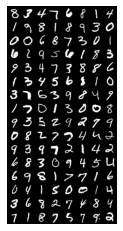

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

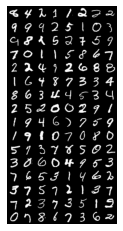

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

In [ ]:
t = time.time()
DATASET_NAME = 'mnist'

# TODO
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=1e-3)  
BATCH_SIZE = 128  
NUM_EPOCHS = 200
sigmas_ = progression[::-1]
all_all_pics = {}

for sig in sigmas_:
    MODEL, loss_and_accuracy_history = pp.training_and_eval(DATASET_NAME, 
                                                                MODEL,
                                                                OPTIMIZER,
                                                                BATCH_SIZE, 
                                                                NUM_EPOCHS,
                                                                augment = False, 
                                                                need_summary = True,
                                                                sigma=sig)
    all_pics = pp.annealed_langevin(MODEL, progression, T = 100)
    all_all_pics[sig] = all_pics
    pickle.dump(all_all_pics, open("all_all_pics_from_small_to_big_350ep.p", "wb"))
    torch.save(MODEL.state_dict(), f"model_params_training_from_small_to_big_sigma_{sig:.2f}_350_epoch_each.pt")

    print(f'\n\n\n#######################\nsig {sig} done in  {time.time()-t} secs \n\n')

Dataset: mnist 
 Image shape: (1, 28, 28) 
 Number of train images: 60000 
 Number of test images: 10000 
 Number of classes: 10 



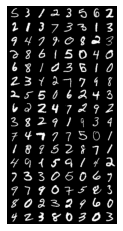

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

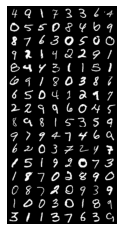

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

In [ ]:
t = time.time()
DATASET_NAME = 'mnist'

# TODO
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=1e-3)  
BATCH_SIZE = 128  
NUM_EPOCHS = 300
sigmas_ = progression[::-1]
all_all_pics = {}

for sig in sigmas_:
    MODEL, loss_and_accuracy_history = pp.training_and_eval(DATASET_NAME, 
                                                                MODEL,
                                                                OPTIMIZER,
                                                                BATCH_SIZE, 
                                                                NUM_EPOCHS,
                                                                augment = False, 
                                                                need_summary = True,
                                                                sigma=sig)
    all_pics = pp.annealed_langevin(MODEL, progression, T = 100)
    all_all_pics[sig] = all_pics
    pickle.dump(all_all_pics, open("all_all_pics_from_small_to_big_450ep.p", "wb"))
    torch.save(MODEL.state_dict(), f"model_params_training_from_small_to_big_sigma_{sig:.2f}_450_epoch_each.pt")

    print(f'\n\n\n#######################\nsig {sig} done in  {time.time()-t} secs \n\n')

In [ ]:
torch.save(MODEL.state_dict(), "model_params_2_all_trained_for210_epochs.pt")

In [5]:
all_all_pics = pickle.load(open("all_all_pics_from_small_to_big_150ep.p", 'rb'))

In [5]:
c = -1
all_pics = all_all_pics[progression[c]]


for k, v in all_all_pics.items():
    all_pics.append(v[2])

AttributeError: ignored

In [6]:
all_all_pics[2.154434690031884]

tensor([[[[-9.5064e-01, -3.7351e+00, -2.1212e-01,  4.1640e+00,  1.8380e+00,
           -6.0059e+00, -1.6204e-02,  1.4199e+00, -9.8570e+00, -7.3846e+00,
           -2.8224e+00,  6.9258e+00, -4.0147e+00, -1.6793e+01, -1.2743e+01,
           -1.8708e+01,  9.3963e+00, -1.4384e+00, -7.2386e+00, -4.6645e+00,
           -4.9265e-01,  3.9129e+00, -2.4972e+00, -1.6356e+01,  7.3474e+00,
           -6.9323e+00,  1.8930e+00,  6.5267e+00],
          [ 1.7115e-01, -8.0421e+00,  4.4178e+00, -6.5285e+00,  1.0192e+00,
           -4.6017e+00,  1.1213e+01, -3.7630e+00, -3.2438e+00,  4.5406e+00,
            5.0614e+00, -2.2564e+00,  7.7770e-01,  6.6962e-01, -1.0906e+01,
           -8.5889e+00, -7.2738e-01,  4.3236e-01, -4.6649e+00,  7.4613e-01,
            3.7897e-01, -6.6471e+00, -1.1504e-01, -5.1703e+00,  5.4707e+00,
            3.5659e-01, -1.5482e+01,  2.2926e+00],
          [ 3.5695e+00, -3.0474e+00,  5.9360e+00,  4.4768e+00,  4.9852e+00,
           -5.8279e+00,  1.6598e+01,  3.6987e+00,  1.1500e+01,

In [21]:

all_all_pics.keys()

dict_keys([10.0, 4.641588833612779, 2.154434690031884, 1.0000000000000002, 0.46415888336127803, 0.21544346900318842, 0.10000000000000003, 0.04641588833612781, 0.021544346900318846, 0.010000000000000007])

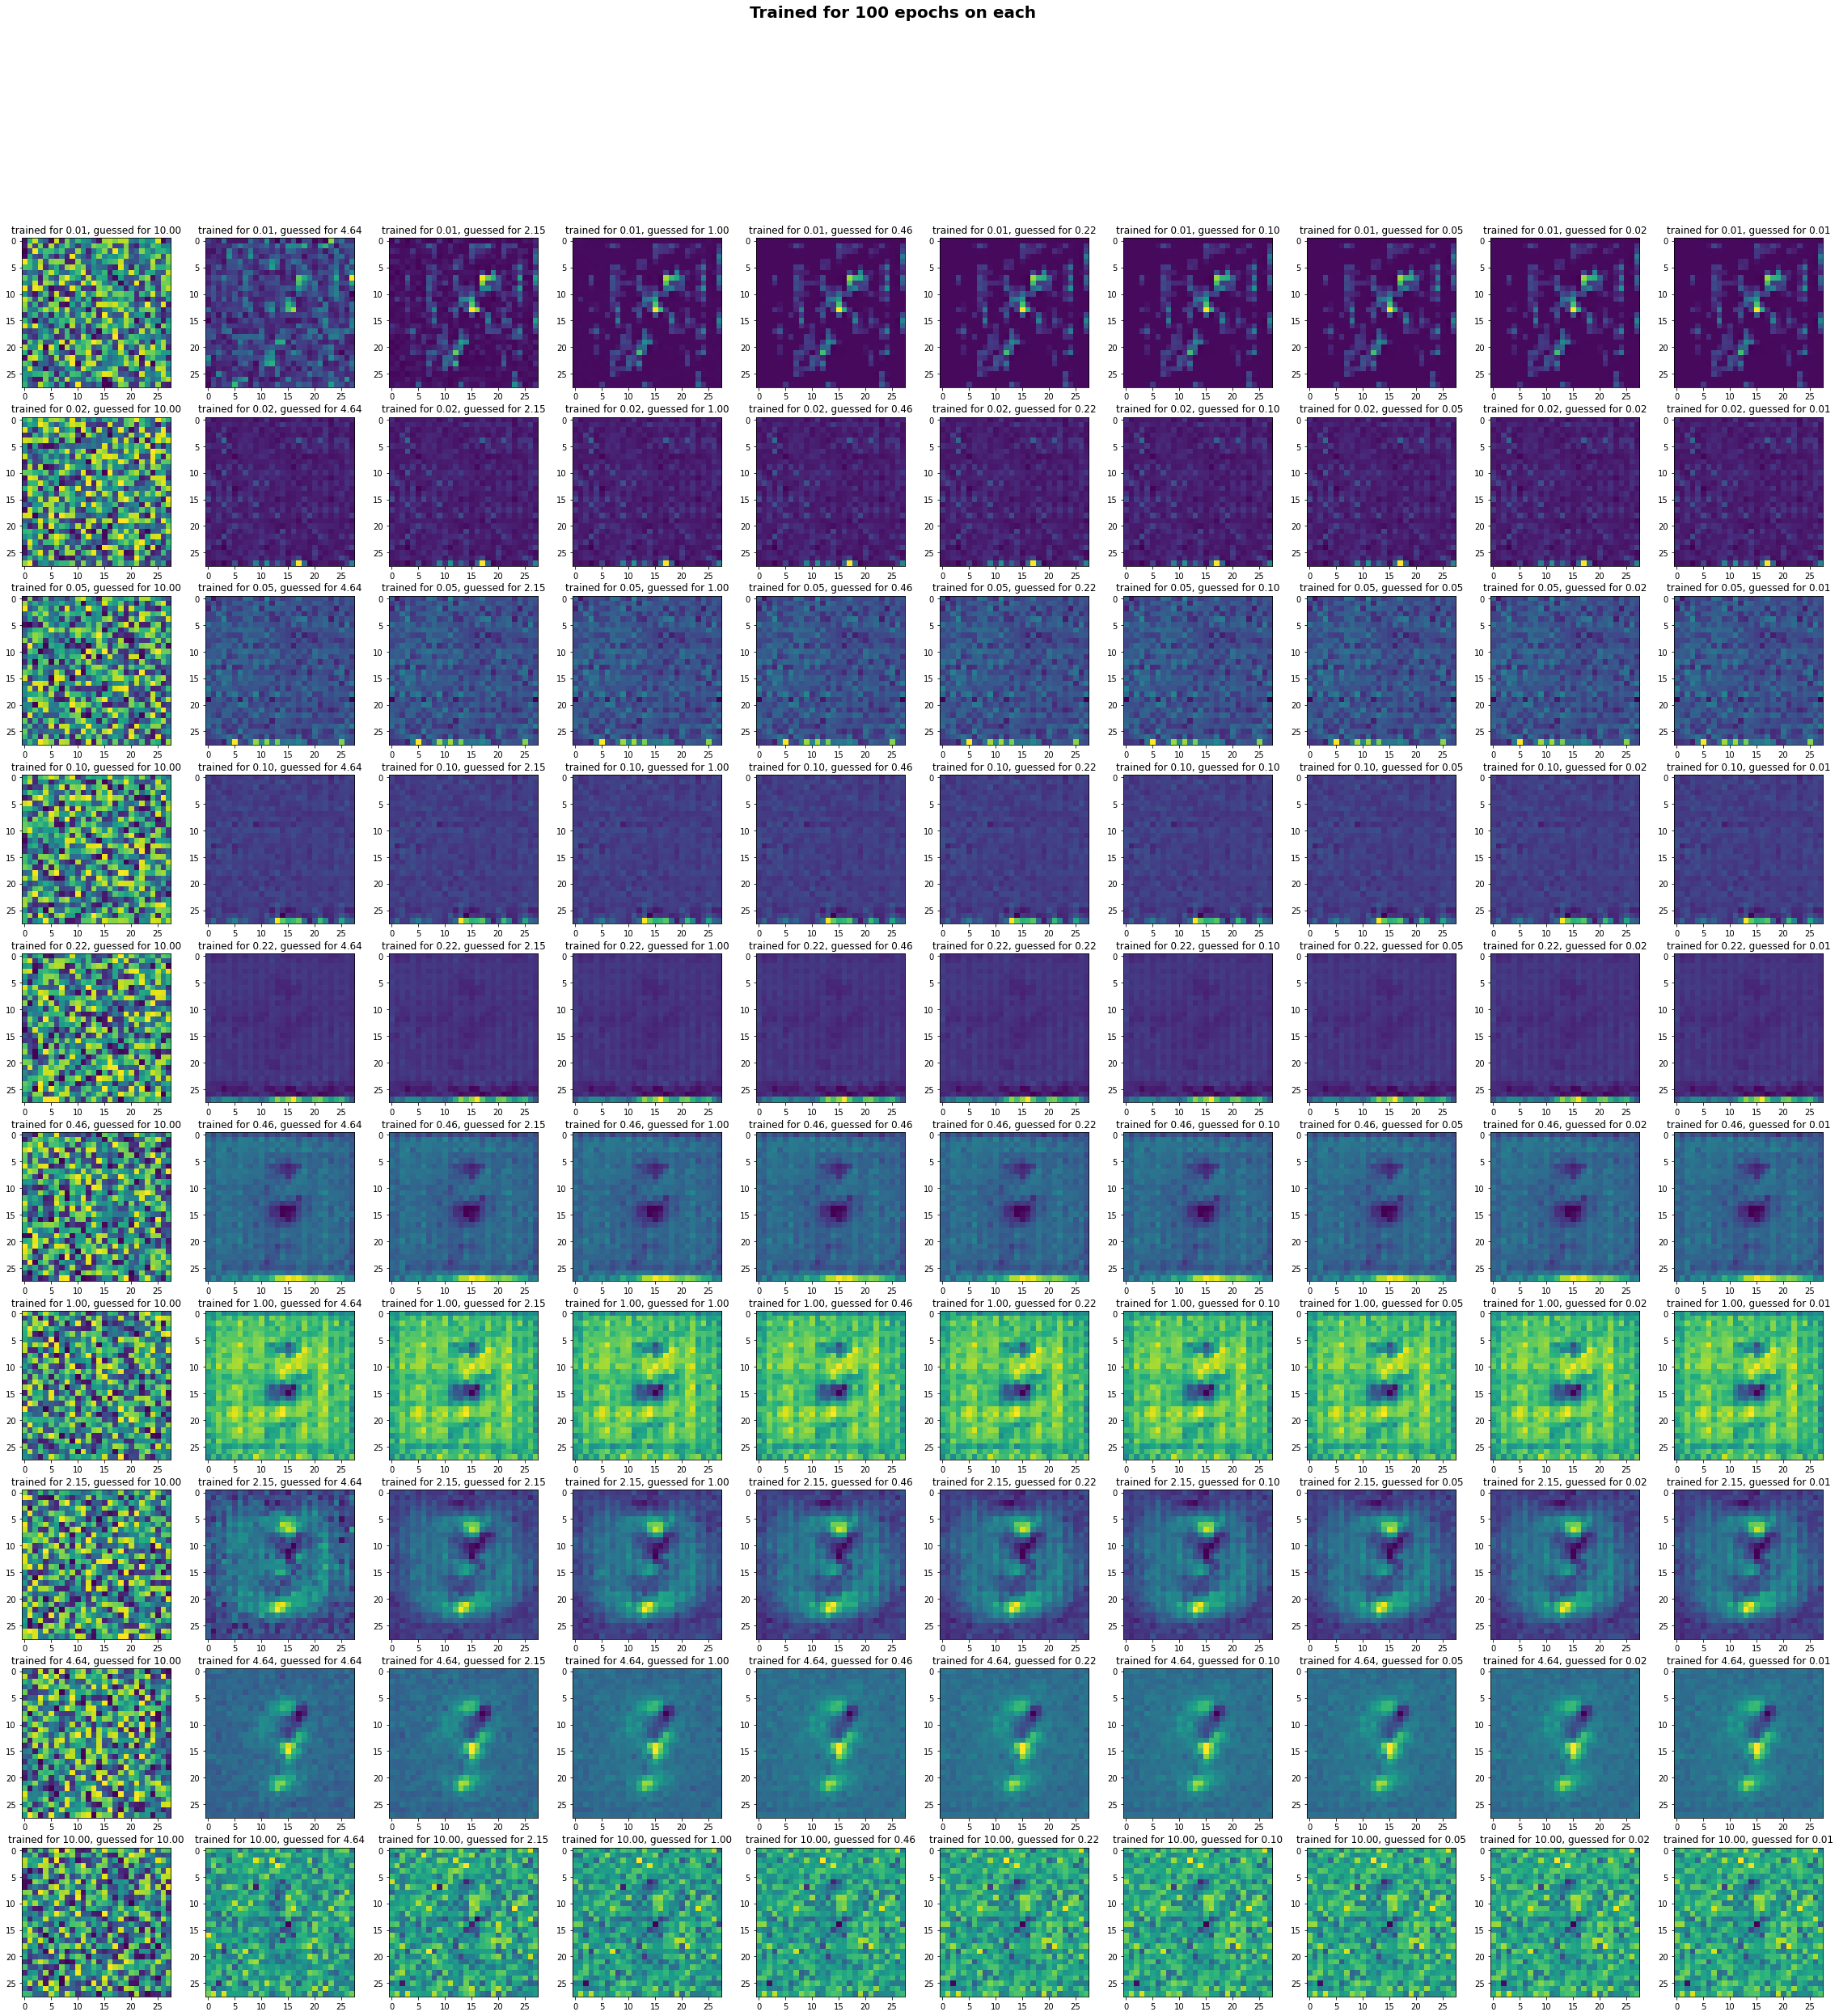

In [7]:
fig, axes = plt.subplots(10,10, figsize=(40, 40))


for r, s_tr  in enumerate(progression[::-1]):
    MODEL = Score(my_tuple)
    MODEL = MODEL.to(torch.cuda.current_device())
    MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)
    MODEL.load_state_dict(torch.load(f"model_params_training_from_small_to_big_sigma_{s_tr:.2f}_150_epoch_each.pt"))
    all_pics = pp.annealed_langevin(MODEL, progression, T = 100, return_all=True)
    for c, s_gu in enumerate(progression):
        ax = axes[r,c]
        im = all_pics[c]
        ax.imshow(im)
        ax.set_title(f"trained for {s_tr:.2f}, guessed for {s_gu:.2f}")
fig.suptitle("Trained for 100 epochs on each", fontsize=20, fontweight = 'bold')
fig.savefig('trained_on_all_from_small_to_big_for_150_epochs.png', dpi = 100)

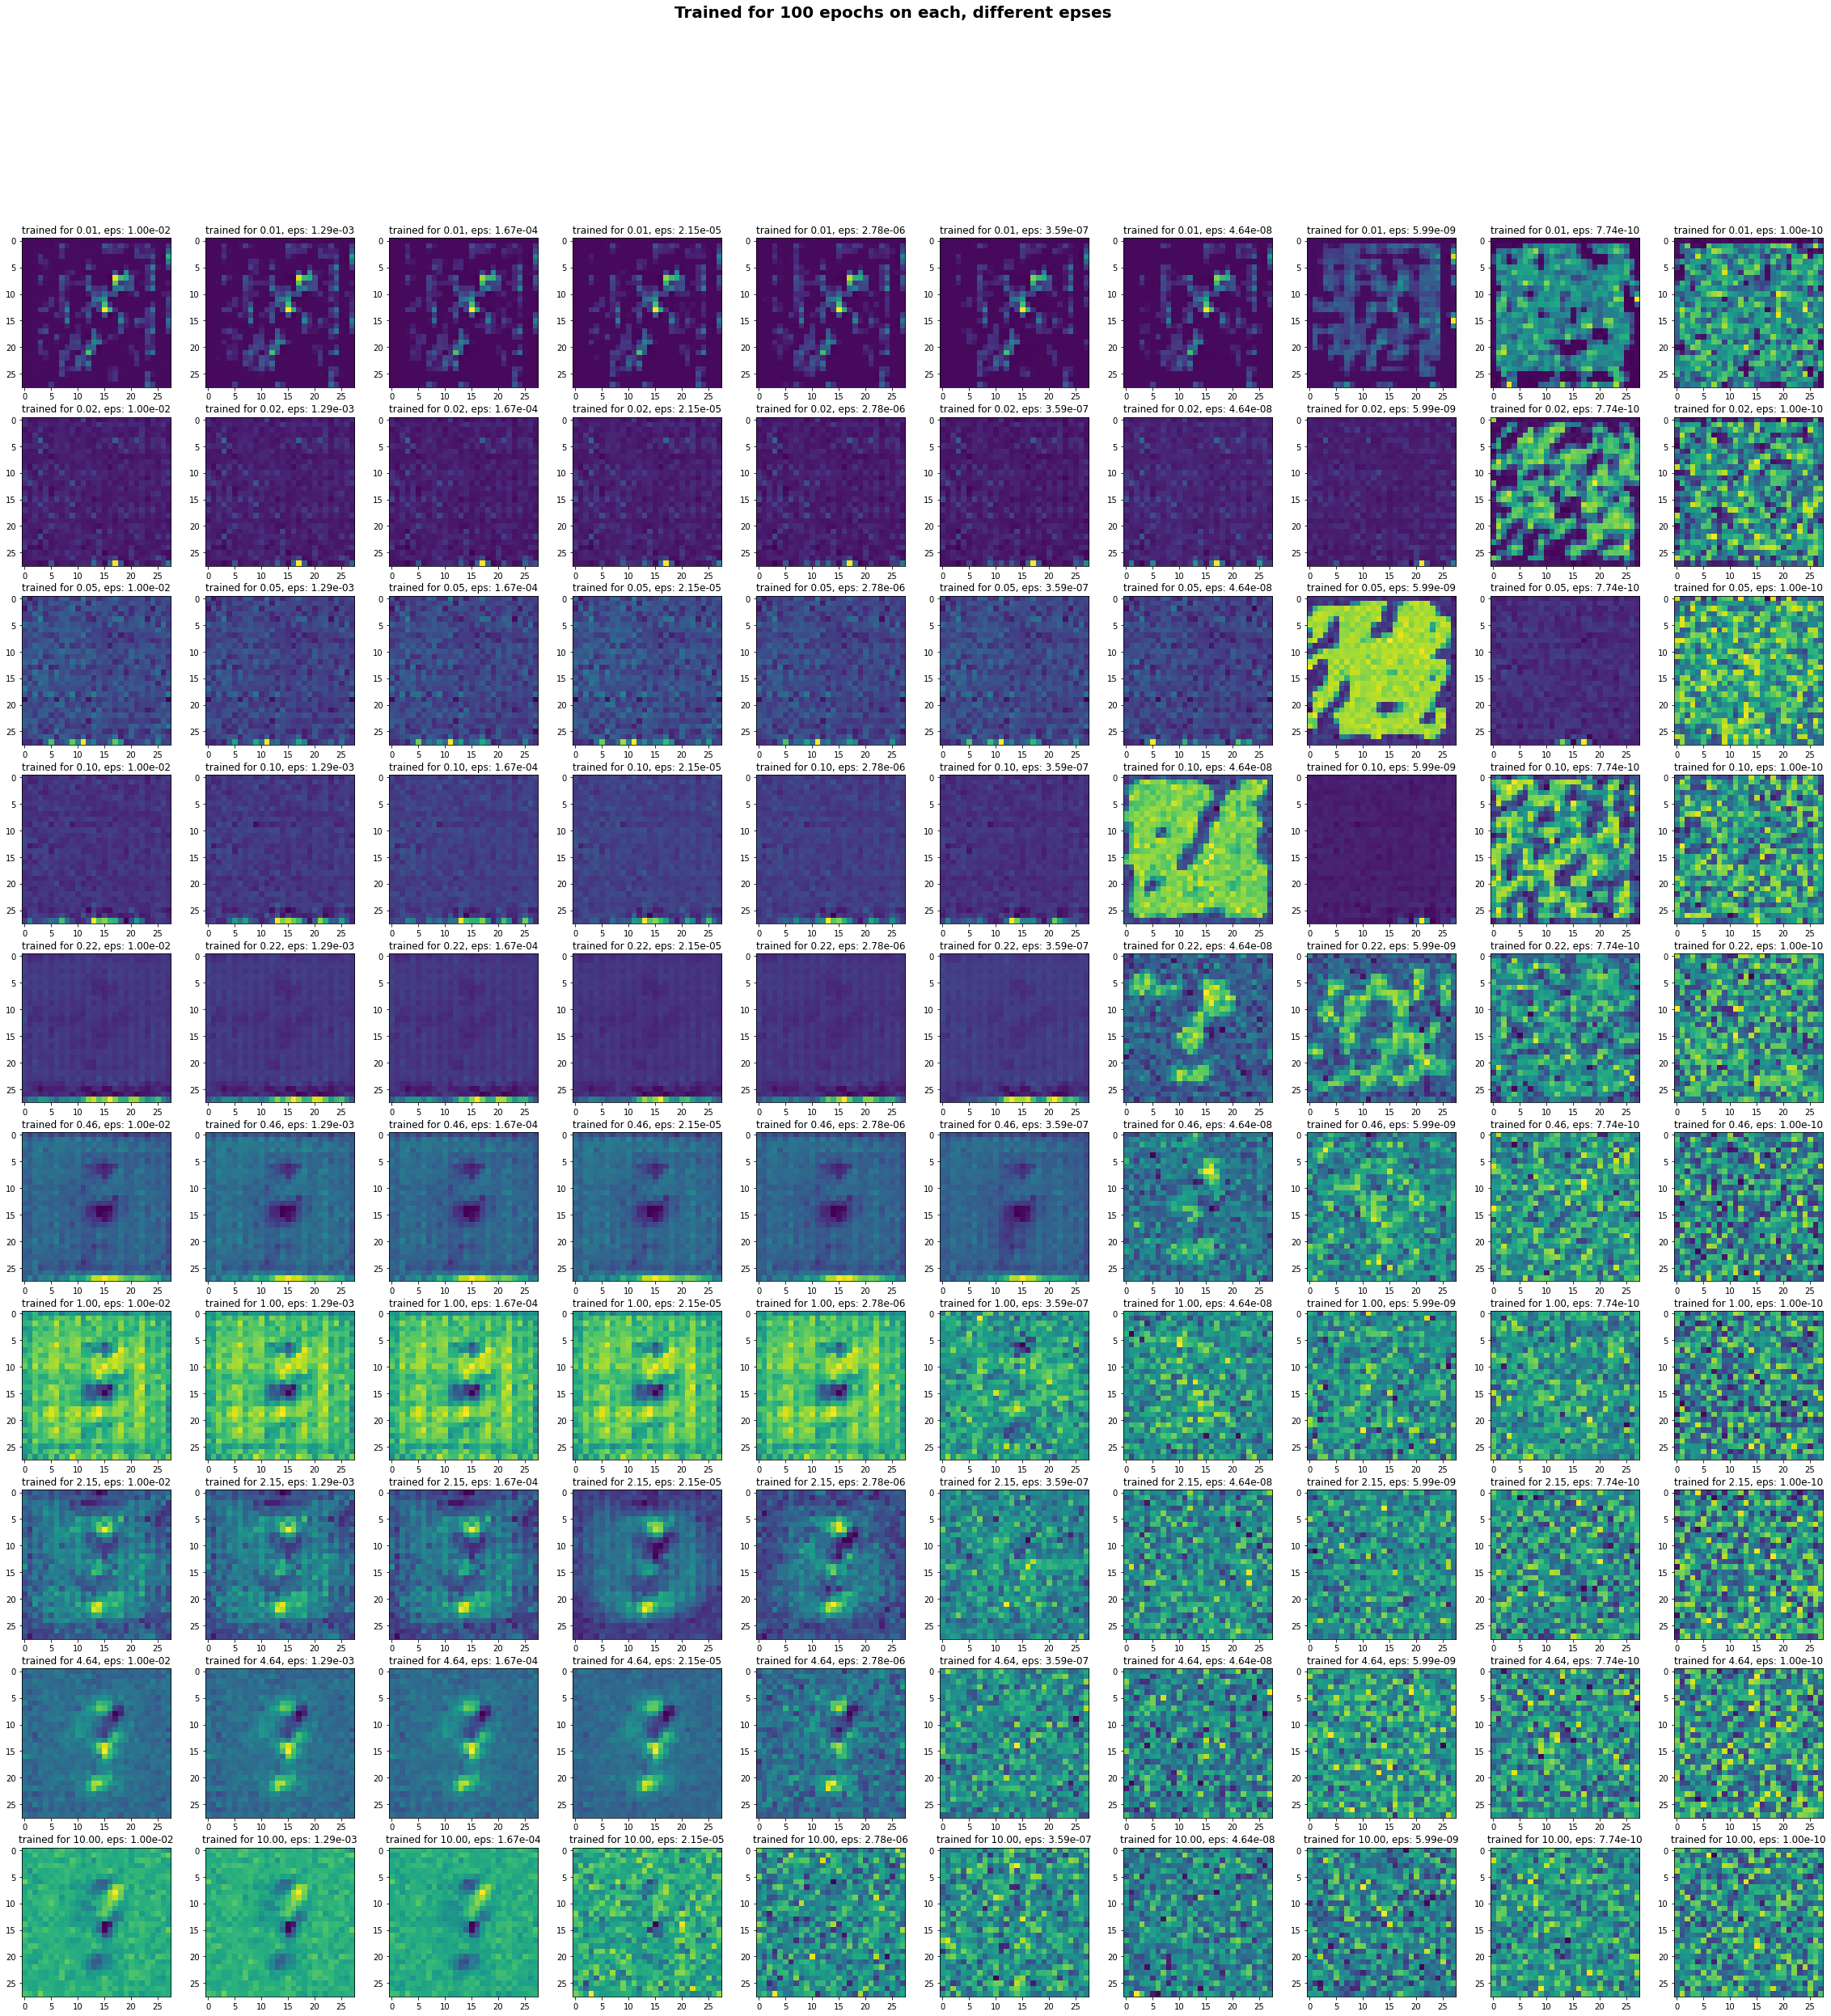

In [20]:
fig, axes = plt.subplots(10,10, figsize=(40, 40))


for r, s_tr  in enumerate(progression[::-1]):
    MODEL = Score(my_tuple)
    MODEL = MODEL.to(torch.cuda.current_device())
    MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)
    MODEL.load_state_dict(torch.load(f"model_params_training_from_small_to_big_sigma_{s_tr:.2f}_150_epoch_each.pt"))
    for c, ep in enumerate(np.logspace(-2, -10, 10)):
        all_pics = pp.annealed_langevin(MODEL, progression, T = 100, eps= ep, return_all=True)
        ax = axes[r,c]
        im = all_pics[-1]
        ax.imshow(im)
        ax.set_title(f"trained for {s_tr:.2f}, eps: {ep:.2e}")
fig.suptitle("Trained for 100 epochs on each, different epses", fontsize=20, fontweight = 'bold')
fig.savefig('trained_on_all_from_small_to_big_for_150_epochs_different_epsilons.png', dpi = 100)

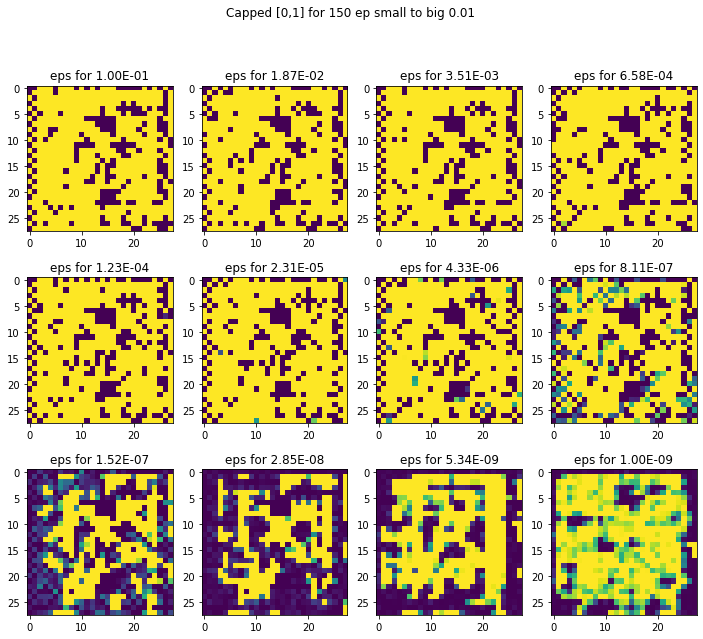

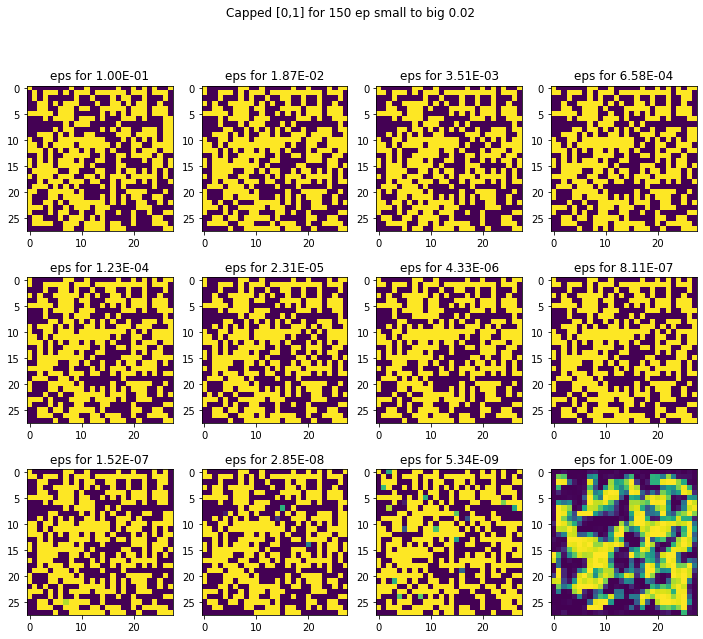

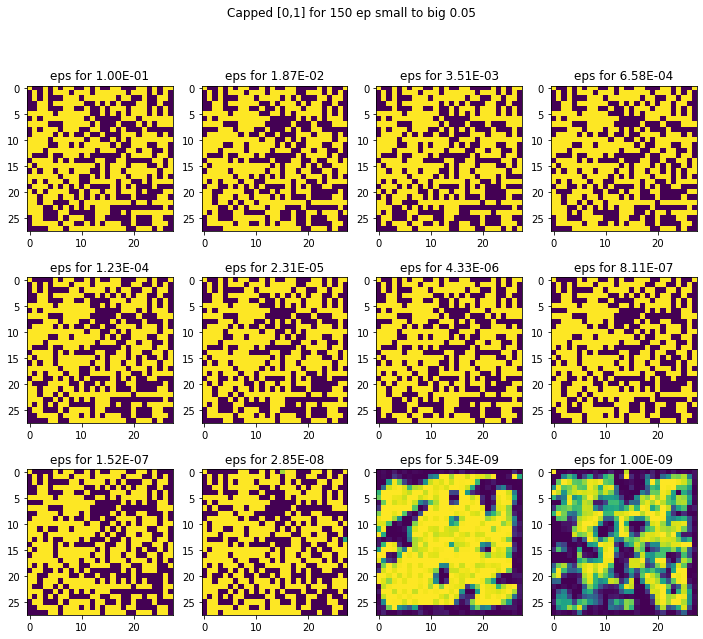

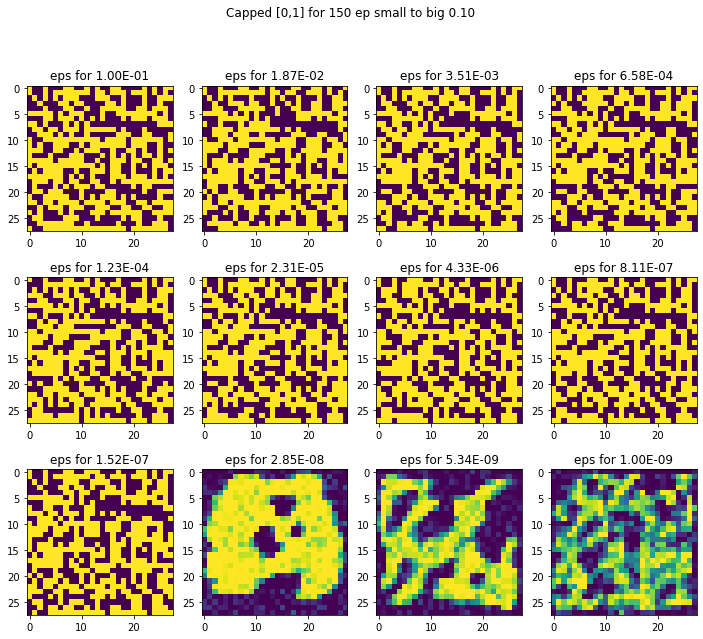

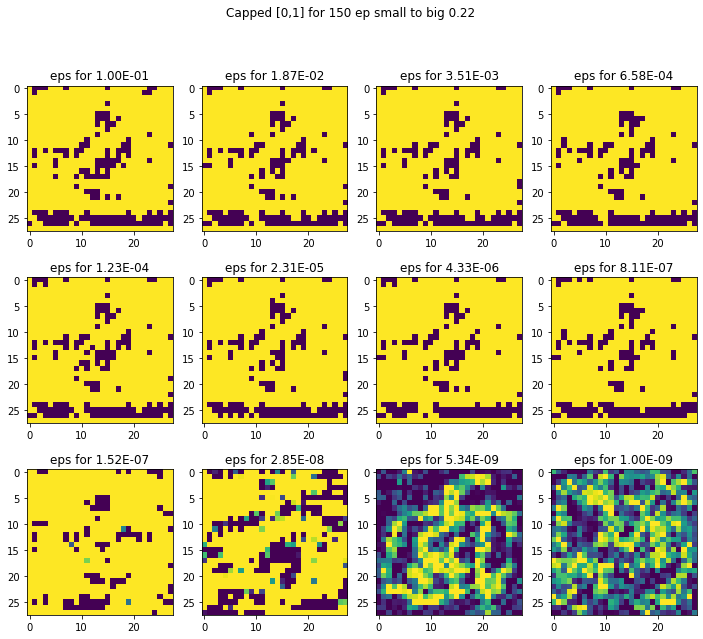

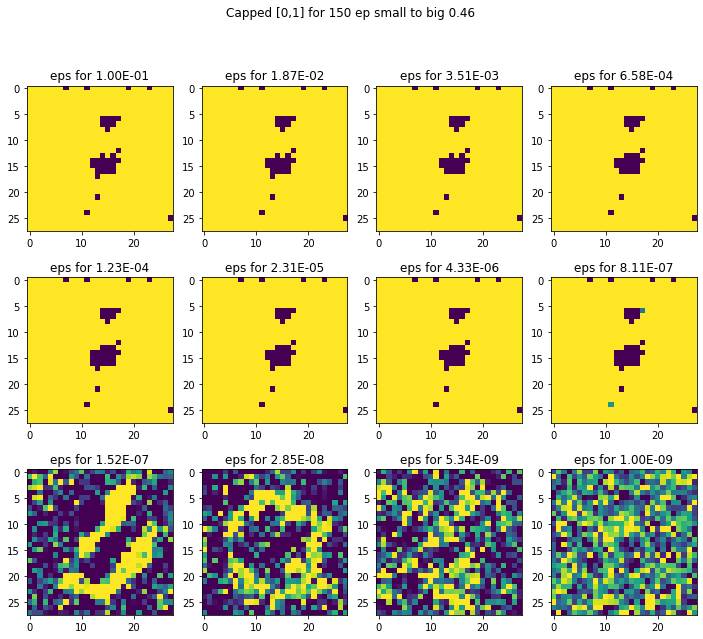

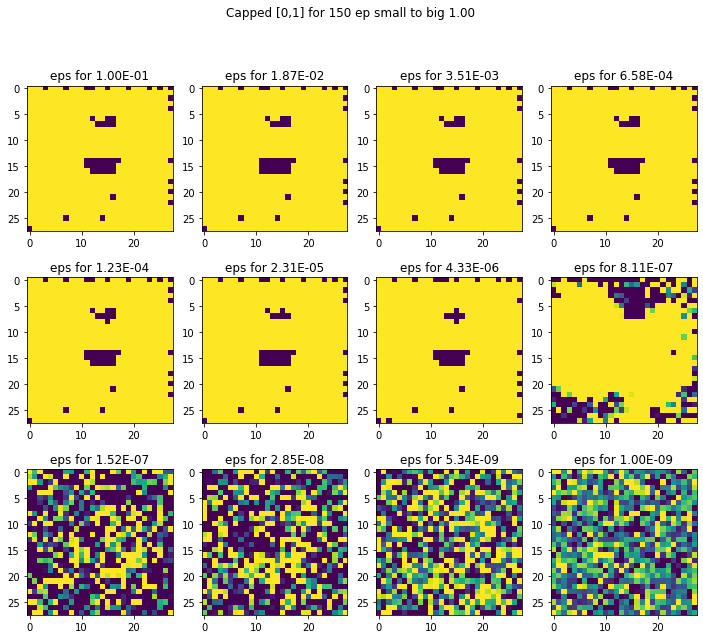

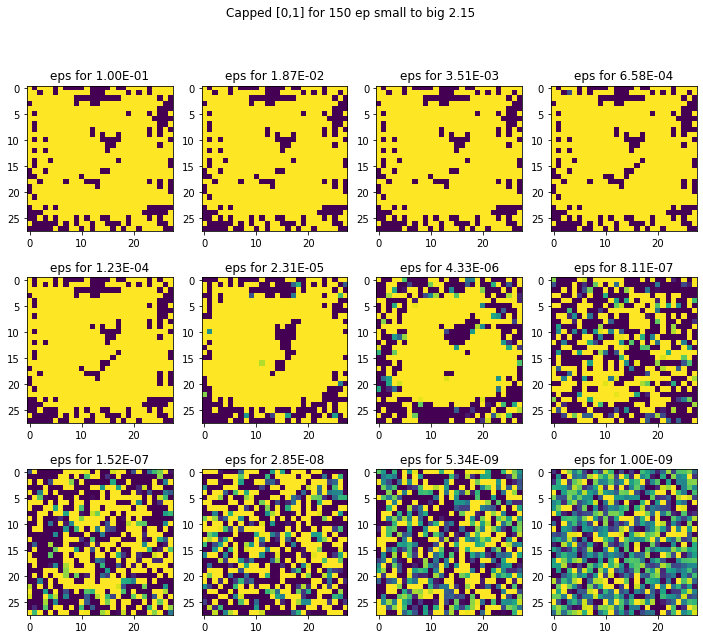

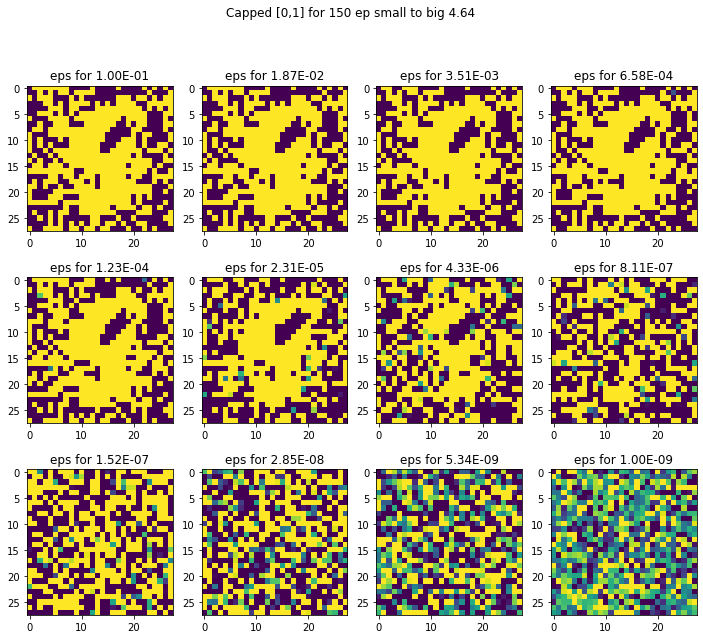

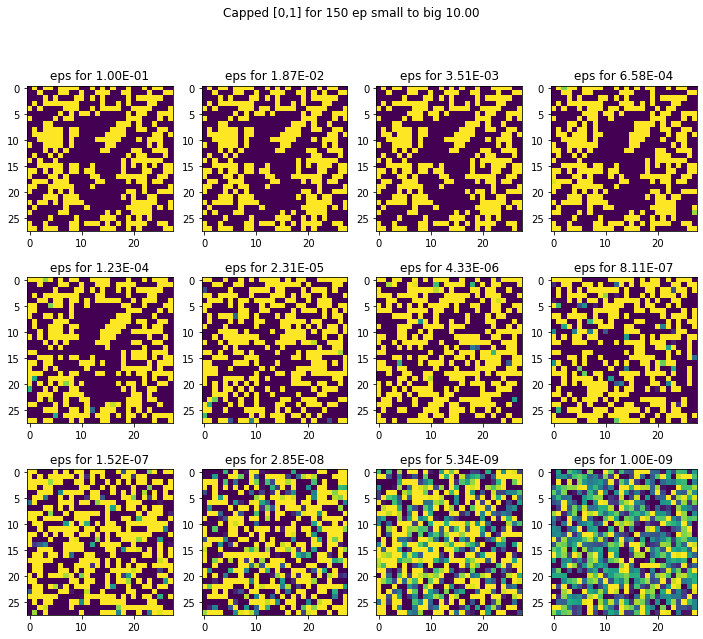

In [34]:

for s in progression[::-1]:
    MODEL = Score(my_tuple)
    MODEL = MODEL.to(torch.cuda.current_device())
    MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)
    MODEL.load_state_dict(torch.load(f"model_params_training_from_small_to_big_sigma_{s:.2f}_150_epoch_each.pt"))
    fig, axes = plt.subplots(3,4, figsize=(12, 10))

    #all_pics = pp.annealed_langevin(MODEL, progression, eps = 2e-9, T = 100, return_all=True)
    for c, (ep, ax) in enumerate(zip(np.logspace(-1, -9, 12),  axes.ravel())):
        all_pics = pp.annealed_langevin(MODEL, progression, eps = ep, T = 100, return_all=True)
        im = all_pics[-1]
        ax.imshow(im, vmin = 0, vmax = 1)
        ax.set_title(f"eps for {ep:.2E}")
    fig.suptitle(f"Capped [0,1] for 150 ep small to big {s:.2f}")
    fig.savefig(f'different_epses_capped_for_150_epochs_sigma_{s:.2f}.png', dpi = 150)

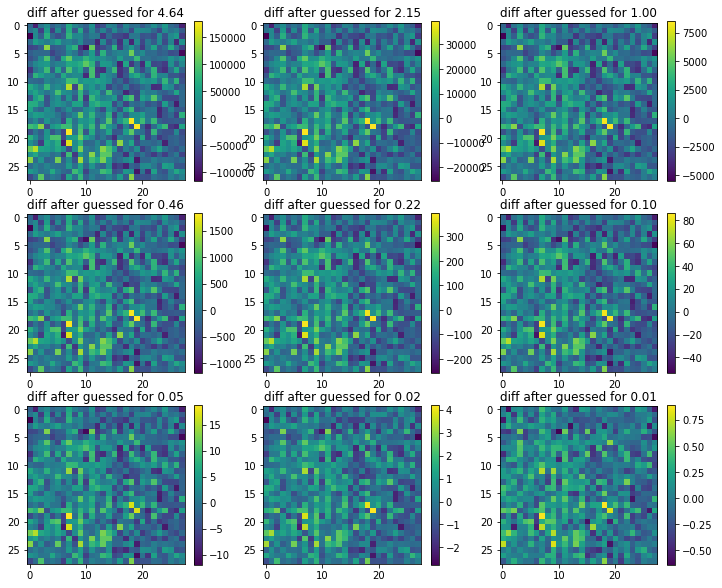

In [24]:
fig, axes = plt.subplots(3,3, figsize=(12, 10))

for c, (s_gu, ax) in enumerate(zip(progression[1:],  axes.ravel())):
    im = all_pics[c+1] - all_pics[c]
    f = ax.imshow(im)
    ax.set_title(f"diff after guessed for {s_gu:.2f}")
    fig.colorbar(f, ax = ax)

## Data loading

In [ ]:
train, test = pp.load_and_preprocess_data("mnist", BATCH_SIZE)

NameError: ignored

In [ ]:
outp = MODEL((train.dataset.data[:32].view(32, 1, 28, 28)/255).to("cuda"))

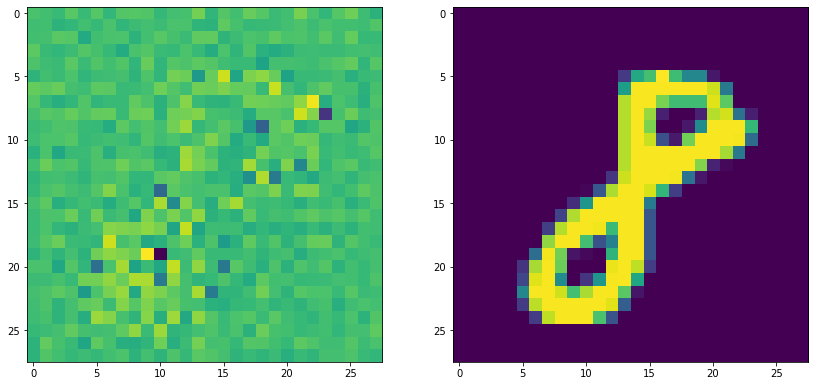

In [ ]:
c = 31
image = outp[c].detach().cpu().numpy().astype(float)

fig, axes = plt.subplots(1,2, figsize=(14, 8))

ax = axes[0]
#ax.imshow(np.moveaxis(image, [0,1,2], [2,0,1]))
ax.imshow(image[0])
ax = axes[1]
ax.imshow(train.dataset.data[c])

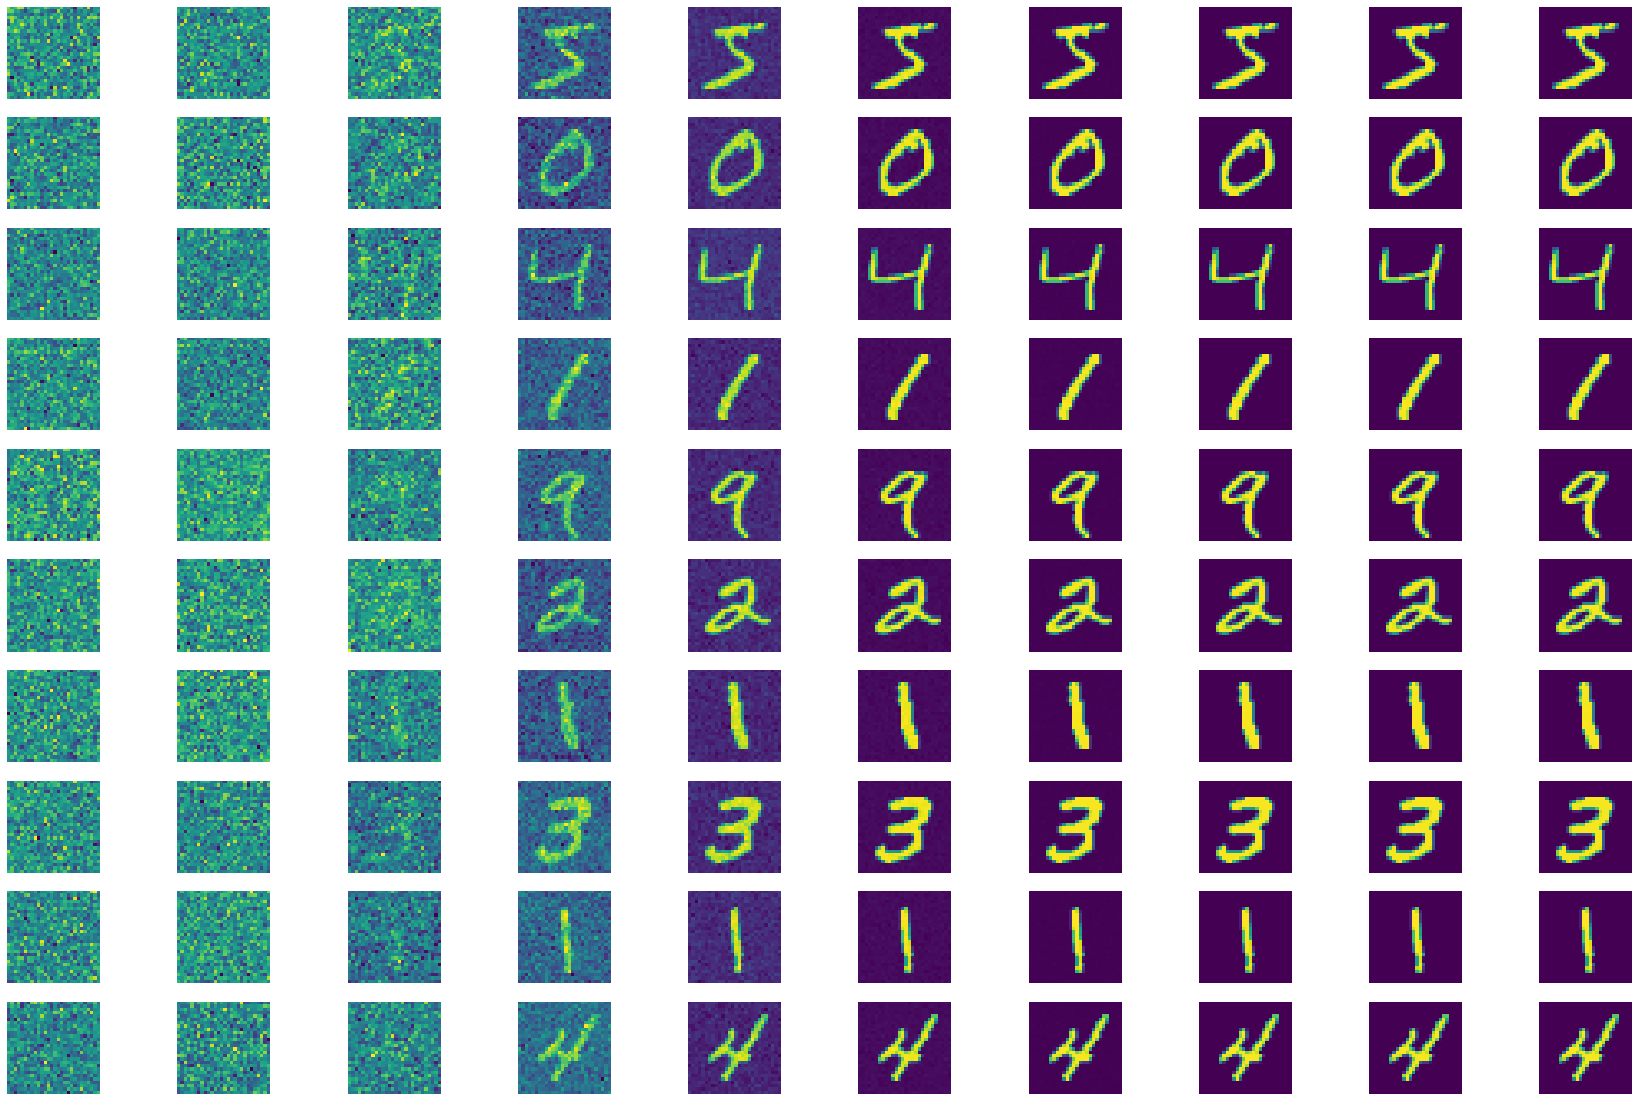

In [ ]:


fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow(im_);
        ax.axis('off')

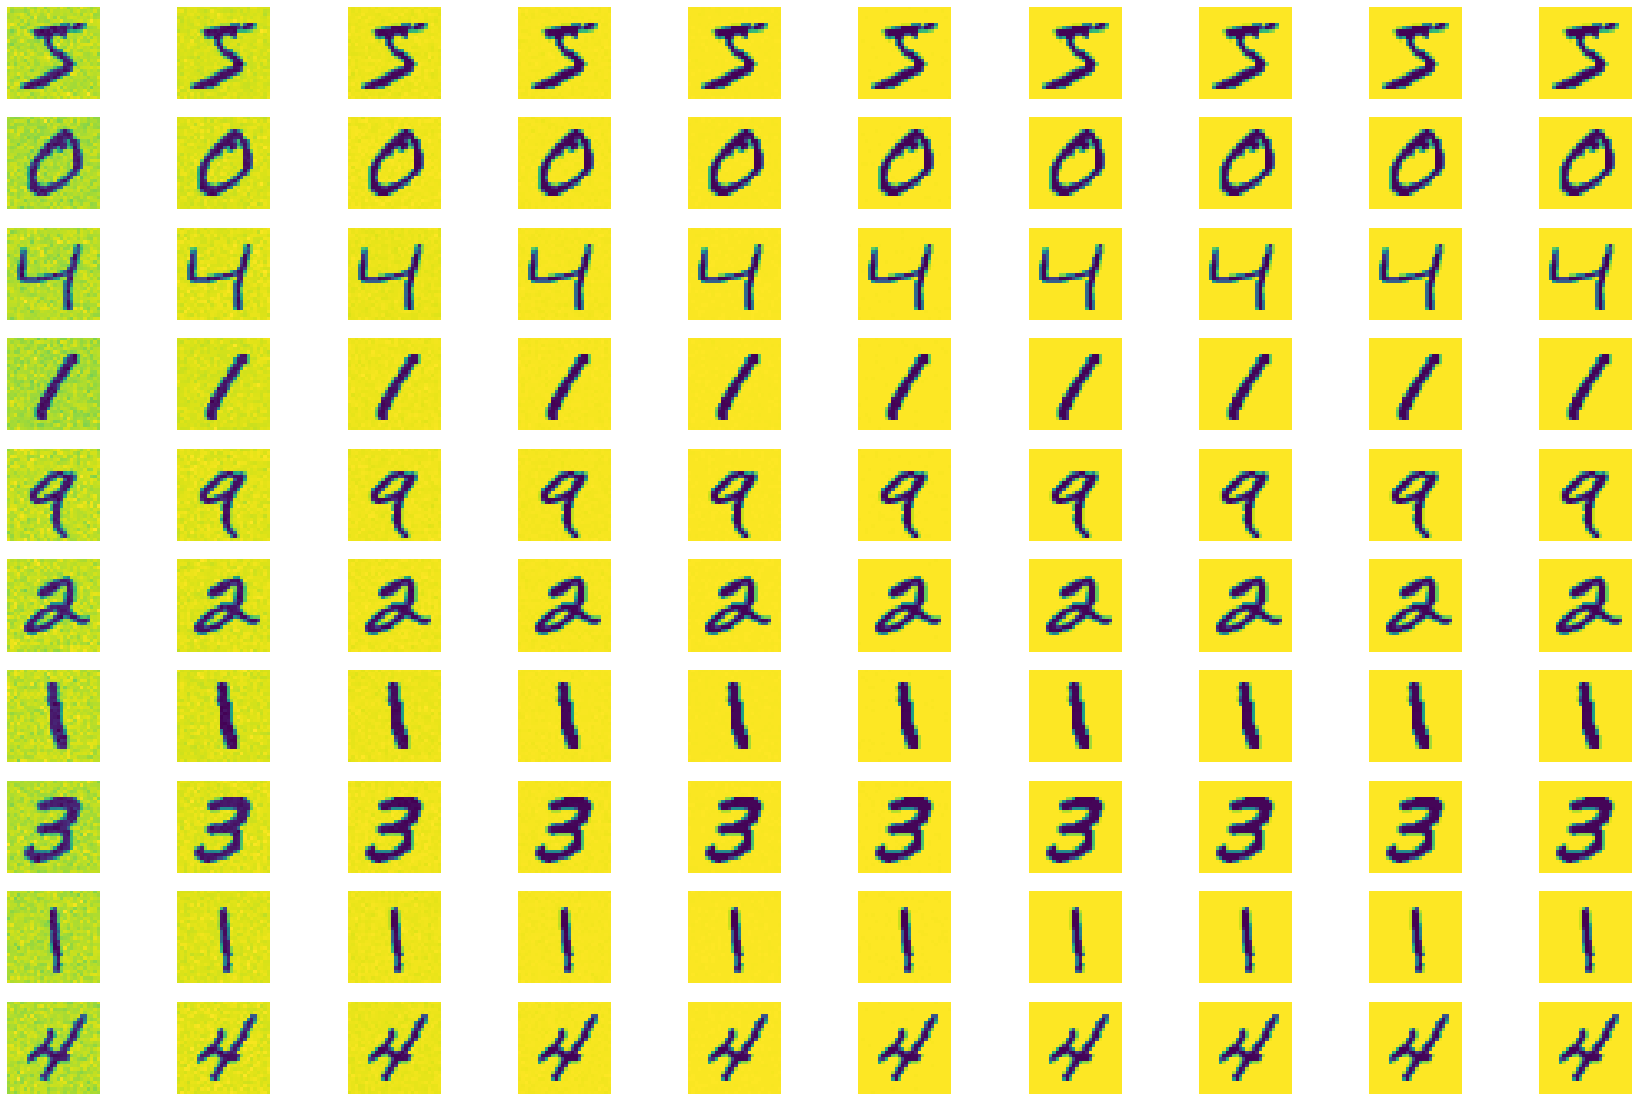

In [ ]:
fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps_ = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow((im_-im)/eps);
        ax.axis('off')

In [ ]:
device = torch.cuda.current_device()
for sigma in epses:

    for i, (images, labels) in enumerate(train):
        images_o = images.to(device)
        #eps_ = (eps**2/progression[-1]**2)*2e-5
        images = images_o + torch.normal(0, std=sigma, size=images.shape).to(device)
        labels = (images-images_o)/sigma

KeyboardInterrupt: ignored

In [ ]:
gen_images = [annealed_langevin(MODEL,progression,e, 100)[0][0].cpu().detach().numpy() for e in epsilons]
#gen_images = [annealed_langevin(MODEL,progression,epsilons[-1], t)[0][0].cpu().detach().numpy() for t in t_s]

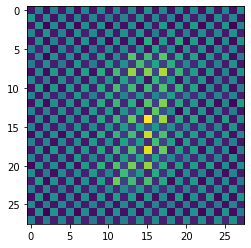

In [ ]:
c = annealed_langevin(loaded_model,progression,2e-5, 100)
plt.imshow(c[0][0].cpu().detach().numpy())

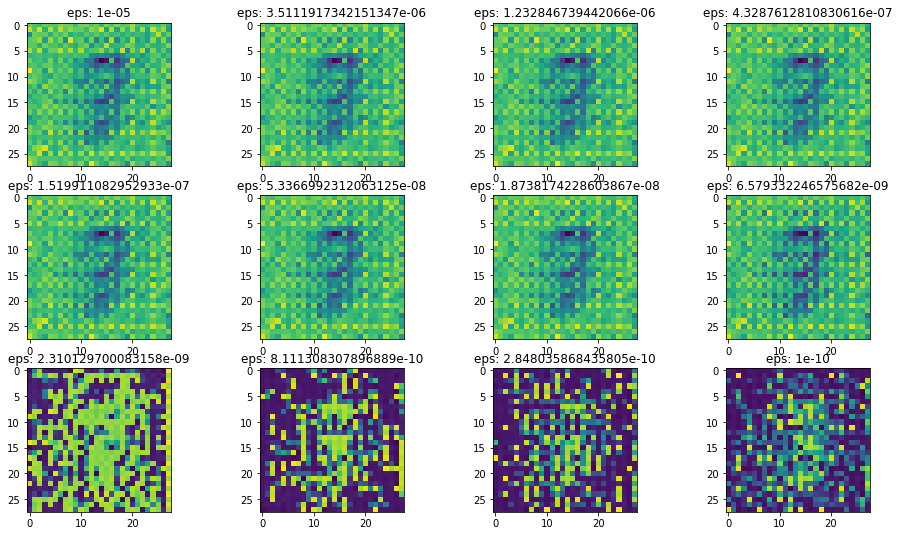

In [ ]:
fig, axes = plt.subplots(3,4, figsize = (16,9))

for im, ax, ep in zip(gen_images, axes.ravel(), epsilons):
    ax.imshow(im)
    ax.set_title(f"eps: {ep}")

fig.savefig('figs/different_epses_appr_310_epochs_for_allsigmas_plus_10sigma.png', dpi = 100)

In [ ]:
progression

array([10.        ,  4.64158883,  2.15443469,  1.        ,  0.46415888,
        0.21544347,  0.1       ,  0.04641589,  0.02154435,  0.01      ])

In [ ]:
    torch.cuda.empty_cache()

In [ ]:
# torch.save(MODEL.state_dict(), "model_params_2_all_trained_for160_epochs.pt")

In [7]:
"""MODEL = Score(my_tuple)
MODEL = MODEL.to(torch.cuda.current_device())
MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)
MODEL.load_state_dict(torch.load("model_params_2_all_trained_for310_epochs_sig10_added.pt"))
""";

In [9]:

!git push

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 813 bytes | 406.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/78furu/deeplea_adv.git
   2efd67a..79628d9  master -> master


In [40]:
!git commit -m "done for from big to small"

[master ac23d38] done for from big to small
 14 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 all_all_pics_from_big_to_small.p
 create mode 100644 model_params_training_from_big_to_small_sigma_0.01_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_0.02_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_0.05_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_0.10_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_0.22_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_0.46_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_1.00_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_10.00_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small_sigma_2.15_50_epoch_each.pt
 create mode 100644 model_params_training_from_big_to_small

In [39]:
!git config --global user.email "78furu@gmail.com"
!git config --global user.name "Furuglyas Kristof"


In [41]:
!git push

Counting objects: 17, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (17/17), done.
Writing objects: 100% (17/17), 74.81 MiB | 14.78 MiB/s, done.
Total 17 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/78furu/deeplea_adv.git
   e3c0105..ac23d38  master -> master
